In [ ]:
!pip install vbeam

# Plane Wave Imaging (PWI)
Let's look at a PWI setup. Today we're beamforming one of the datasets from the PICMUS challenge _(Liebgott et al., ‘Plane-Wave Imaging Challenge in Medical Ultrasound’)_. Let's download it from [ustb.no](https://www.ustb.no/ustb-datasets/) and import it. We create a basic DAS beamformer using `get_das_beamformer` and JIT-compile it using JAX.

In [2]:
import jax
from pyuff_ustb import Uff

from vbeam.beamformers import get_das_beamformer
from vbeam.data_importers import import_pyuff
from vbeam.util.download import cached_download

data_url = "http://www.ustb.no/datasets/PICMUS_carotid_cross.uff"
uff = Uff(cached_download(data_url))
channel_data = uff.read("/channel_data")
scan = uff.read("/scan")

setup = import_pyuff(channel_data, scan, frames=0)
#setup.scan = setup.scan.resize(x=200, z=400)
beamformer = jax.jit(get_das_beamformer(setup))

/home/magnusk/miniconda3/envs/vbeam/lib/python3.9/site-packages/pyuff_ustb/objects/point.py:60: RuntimeWarning: invalid value encountered in multiply
  return self.distance * np.sin(self.elevation)
/home/magnusk/miniconda3/envs/vbeam/lib/python3.9/site-packages/pyuff_ustb/objects/point.py:56: RuntimeWarning: invalid value encountered in multiply
  return self.distance * np.sin(self.azimuth) * np.cos(self.elevation)


## Plotting the Result
This is what the image looks like:

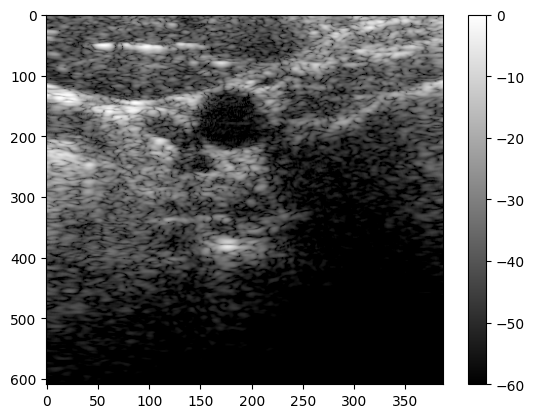

In [3]:
import matplotlib.pyplot as plt

result = beamformer(**setup.data)
plt.imshow(result.T, aspect="auto", cmap="gray", vmin=-60)
plt.colorbar()

## How Fast is the Beamformer?
In the code cell below we are timing the beamformer using `%timeit`. There are 75 transmitted waves, 128 receiving elements, and the scan is 387x609 pixels. This amounts to 75x128x387x609 ≈ 2.3 billion points to be processed for one image. vbeam beamforms this image in 185 milliseconds, on average, on a Nvidia A100 GPU.

In [4]:
from math import prod

data = setup.data
%timeit beamformer(**data).block_until_ready()

num_points_to_be_processed = prod(setup.size(["transmits", "receivers", "points"]))
points_per_second = num_points_to_be_processed / 0.185
print(f"{points_per_second:.1e} points processed per second")

187 ms ± 3.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.2e+10 points processed per second


## How Fast is it to Beamform Just One Plane Wave?
This dataset has data for 75 transmitted plane waves, and vbeam uses 185 milliseconds to beamform them all. How fast is vbeam when it only has to beamform a single plane wave?

The cell below slices the data such that only the plane wave at index 37 in the data is included. We then beamform and time it again using `%timeit`. vbeam uses around 3.36 milliseconds to beamform a single plane wave for this setup, amounting to approximately 9 billion points per second. This is a lower number than in the previous example, likely due to not utilizing the GPU as efficiently.

/home/magnusk/vbeam/vbeam/data_importers/setup.py:45: UserWarning: point_position will be overwritten by the scan.
  warnings.warn("point_position will be overwritten by the scan.")
/home/magnusk/vbeam/vbeam/data_importers/setup.py:54: UserWarning: Both point_position and scan are set. Scan will be used.
  warnings.warn(


4.28 ms ± 982 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


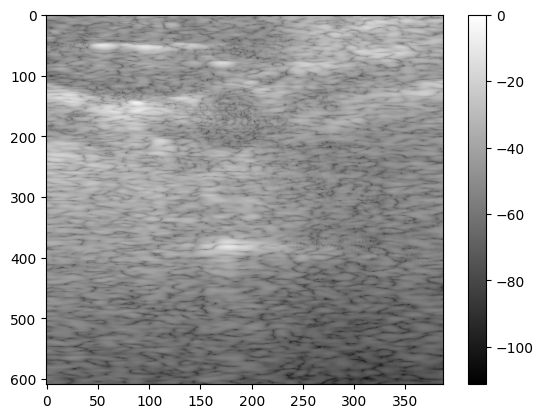

In [5]:
setup_1_transmit = setup.slice["transmits", 37]
beamformer_1_transmit = jax.jit(get_das_beamformer(setup_1_transmit))
result_1_transmit = beamformer_1_transmit(**setup_1_transmit.data).block_until_ready()
plt.imshow(result_1_transmit.T, aspect="auto", cmap="gray")
plt.colorbar()

data_1_transmit = setup_1_transmit.data
%timeit beamformer_1_transmit(**data_1_transmit).block_until_ready()